In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/total_data.csv")

In [2]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
df.rename(columns={"full_date": "date_time",
                  "pm": "value"}, inplace=True)

In [233]:
import math
from sklearn.base import BaseEstimator, TransformerMixin

# If you need holidays:
#   pip install holidays
import holidays

class DateTimeFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, country='KZ'):
        self.country = country
        self.holiday_calendar = holidays.CountryHoliday(self.country, years=[2017,2018,2019,2020])
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Ensure we have a datetime column
        X = X.copy()
        if not np.issubdtype(X['date_time'].dtype, np.datetime64):
            X['date_time'] = pd.to_datetime(X['date_time'])
        
        # Basic time features
        X['year'] = X['date_time'].dt.year
        X['month'] = X['date_time'].dt.month
        X['day_of_week'] = X['date_time'].dt.weekday  # Monday=0, Sunday=6
        X['day_of_year'] = X['date_time'].dt.dayofyear
        
        # Holiday feature
        X['is_holiday'] = X['date_time'].dt.date.astype(str).isin(self.holiday_calendar)
        X['is_holiday'] = X['is_holiday'].astype(int)
        
        # Trend (days from min date)
        diff = X['date_time'] - X['date_time'].min()
        X['trend'] = diff.dt.days
        
        # Example custom cyclical yearly features (like sin/cos with period=365)
        X['f1s'] = np.sin(X['trend'] * 2 * math.pi / 365)
        X['f1c'] = np.cos(X['trend'] * 2 * math.pi / 365)
        
        
        # More harmonic expansions if you want them
        X['f2s'] = np.sin(X['trend'] * 2 * math.pi / (365 * 2))
        X['f2c'] = np.cos(X['trend'] * 2 * math.pi / (365 * 2))
        # etc.

        # Drop original date_time if you don't need it
        
        return X


In [87]:
from sklearn.base import BaseEstimator, TransformerMixin

class LagRollingFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, lags=[1, 7], windows=[3, 7]):
        """
        lags: list of lag offsets, e.g., [1,7] means create value_lag1, value_lag7.
        windows: list of rolling windows in days, e.g., [3,7] means rolling_3_mean, rolling_3_std, etc.
        """
        self.lags = lags
        self.windows = windows

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        # Ensure data is sorted by date_time
        if not X['date_time'].is_monotonic_increasing:
            X.sort_values('date_time', inplace=True)

        # Create lag features
        for lag in self.lags:
            X[f'value_lag{lag}'] = X['value'].shift(lag)

        # Create rolling statistics features
        for w in self.windows:
            shifted_series = X['value'].shift(1)  # Ensure rolling doesn't use the current row
            X[f'value_roll{w}_mean'] = shifted_series.rolling(w).mean()
            X[f'value_roll{w}_std'] = shifted_series.rolling(w).std()
            # X[f'value_roll{w}_min'] = shifted_series.rolling(w).min()
            # X[f'value_roll{w}_max'] = shifted_series.rolling(w).max()
            X[f'value_roll{w}_median'] = shifted_series.rolling(w).median()
            X[f'value_roll{w}_sum'] = shifted_series.rolling(w).sum()
            # X[f'value_roll{w}_div_max_min'] = (
                # X[f'value_roll{w}_max'] / (X[f'value_roll{w}_min'] + 1e-9)
            # )  # Avoid division by zero
            # X[f'value_roll{w}_range'] = X[f'value_roll{w}_max'] - X[f'value_roll{w}_min']

        # Drop rows with NaN values created due to lagging/rolling

        return X


In [88]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.features_to_drop_ = None
    
    def fit(self, X, y=None):
        # Only numeric columns can be correlated
        numeric_cols = X.select_dtypes(include=np.number).columns
        
        corr_matrix = X[numeric_cols].corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        to_drop = []
        for col in upper.columns:
            if any(upper[col] > self.threshold):
                to_drop.append(col)
        
        self.features_to_drop_ = list(set(to_drop))
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        if self.features_to_drop_:
            X.drop(columns=self.features_to_drop_, inplace=True, errors='ignore')
        return X


In [4]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [90]:
feature_creation_pipeline = Pipeline([
    ("datetime_features", DateTimeFeatureEngineer(country='KZ')),
    ("lag_rolling", LagRollingFeatureEngineer(
        lags=[1,7, 30, 60, 90, 120, 150, 180, 250, 300, 365], 
        windows=[3,7, 15, 30, 50, 70, 90, 120])
        ),
])

df_features = feature_creation_pipeline.fit_transform(df)

In [91]:
df_features.head(1)

,date_time,value,year,month,day_of_week,day_of_year,is_holiday,trend,f1s,f1c,...,value_roll70_median,value_roll70_sum,value_roll90_mean,value_roll90_std,value_roll90_median,value_roll90_sum,value_roll120_mean,value_roll120_std,value_roll120_median,value_roll120_sum
0,2017-03-22,91.982979,2017,3,2,81,0,0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
all_feature_cols = list(df_features.columns)
all_feature_cols.remove('value')       # remove target
if 'date_time' in all_feature_cols:
    all_feature_cols.remove('date_time')  # often we drop date_time for modeling


In [42]:
def preprocess_features(df_features, feature_cols, target_col, corr_threshold=0.95):
    """
    Preprocess features to eliminate high correlation redundancies.
    
    Parameters:
        df_features (pd.DataFrame): DataFrame containing all features and the target column.
        feature_cols (list): List of feature column names.
        target_col (str): Name of the target column ('value').
        corr_threshold (float): Threshold for correlation to consider features as redundant.
    
    Returns:
        list: Reduced list of feature column names after removing highly correlated features.
    """
    # Calculate correlation matrix
    corr_matrix = df_features[feature_cols].corr().abs()

    # Identify highly correlated feature pairs
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    correlated_groups = [
        set(upper.columns[upper[column] > corr_threshold].tolist() + [column])
        for column in upper.columns if any(upper[column] > corr_threshold)
    ]
    
    # Deduplicate groups
    correlated_groups = [list(group) for group in {frozenset(group) for group in correlated_groups}]

    # Select the best feature from each group
    reduced_features = set(feature_cols)
    for group in correlated_groups:
        # Evaluate each feature in the group
        best_feature = None
        best_corr = -np.inf

        for feature in group:
            corr_with_target = abs(df_features[[feature, target_col]].corr().iloc[0, 1])
            if corr_with_target > best_corr:
                best_feature = feature
                best_corr = corr_with_target

        # Remove all but the best feature from the group
        reduced_features.difference_update(group)
        reduced_features.add(best_feature)

    return list(reduced_features)

# Example Usage
# Assuming `df_features` is your dataset and `all_feature_cols` contains all features
reduced_feature_cols = preprocess_features(df_features, feature_cols=all_feature_cols, target_col='value', corr_threshold=0.75)

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

def evaluate_subset(feature_cols, df_features, do_scale=True):
    """
    feature_cols: list of columns from df_features (excluding 'value') 
    df_features: the full dataframe with all potential columns (NaNs included)
    do_scale: whether to do StandardScaler or not
    
    returns: dict of mean scores (MSE, RMSE, MAE, MAPE) across folds
    """
    
    # 1) Subset the columns + target
    needed_cols = feature_cols + ['value']  # add target
    df_sub = df_features[needed_cols].copy()
    
    # 2) Drop rows that are NaN in these columns
    df_sub.dropna(subset=needed_cols, inplace=True)
    df_sub.reset_index(drop=True, inplace=True)
    
    # If everything got dropped, just return None or large error
    if df_sub.shape[0] < 10:
        return {
            'MSE': np.nan,
            'RMSE': np.nan,
            'MAE': np.nan,
            'MAPE': np.nan,
            'N': df_sub.shape[0]
        }
    
    # 3) Prepare X, y
    X = df_sub[feature_cols]
    y = df_sub['value']
    
    # 4) Time series split
    tscv = TimeSeriesSplit(n_splits=3)  # for demonstration, 3 folds
    mse_list, rmse_list, mae_list, mape_list = [], [], [], []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Optionally scale
        if do_scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        # Train
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Evaluate
        mse_val = mean_squared_error(y_test, y_pred)
        rmse_val = np.sqrt(mse_val)
        mae_val = mean_absolute_error(y_test, y_pred)
        mape_val = mape(y_test, y_pred)
        
        mse_list.append(mse_val)
        rmse_list.append(rmse_val)
        mae_list.append(mae_val)
        mape_list.append(mape_val)
    
    return {
        'MSE':  np.mean(mse_list),
        'RMSE': np.mean(rmse_list),
        'MAE':  np.mean(mae_list),
        'MAPE': np.mean(mape_list),
        'N':    df_sub.shape[0]
    }


In [45]:
df_features_train = df_features[df_features.date_time < "2020-03-01"]
df_features_oot = df_features[df_features.date_time >= "2020-03-01"]

In [57]:
import random

num_random_tries = 10000
results = []

for i in range(num_random_tries):
    # Randomly choose size
    size = random.randint(3, 8)  # pick 3-8 features
    # Randomly sample "size" features
    # chosen = random.sample(reduced_feature_cols, size)
    chosen = random.sample(all_feature_cols, size)
    
    scores = evaluate_subset(chosen, df_features_train, do_scale=True)
    
    res = {
        'try': i+1,
        'chosen_features': chosen,
        'MSE':  scores['MSE'],
        'RMSE': scores['RMSE'],
        'MAE':  scores['MAE'],
        'MAPE': scores['MAPE'],
        'N_rows_used': scores['N']
    }
    results.append(res)

results_df = pd.DataFrame(results)
results_df


,try,chosen_features,MSE,RMSE,MAE,MAPE,N_rows_used
0,1,"[value_roll30_sum, value_roll30_range, trend, ...",840.227812,28.683248,20.479128,51.112298,1000
1,2,"[value_lag90, value_roll50_mean, value_roll15_...",599.125007,23.877493,16.435118,37.198377,980
2,3,"[value_roll15_std, value_roll50_max, value_rol...",636.052988,24.093361,17.187904,41.756216,950
3,4,"[day_of_year, value_roll30_median, value_roll3...",1031.757574,28.572333,21.963479,49.656315,770
4,5,"[value_lag1, value_roll50_std, value_lag60, va...",394.730577,19.469741,13.221021,27.823609,1010
...,...,...,...,...,...,...,...
9995,9996,"[value_roll30_range, value_roll120_div_max_min...",1083.005777,32.482674,23.403675,76.020250,950
9996,9997,"[value_lag150, value_roll15_range, value_roll9...",734.025478,26.889532,18.645241,48.147402,920
9997,9998,"[value_roll50_sum, value_roll90_max, value_rol...",770.073416,25.181382,18.457907,34.283264,705
9998,9999,"[year, value_roll120_max, f2s, value_roll3_min...",656.926208,24.555648,17.670474,40.361387,950


In [58]:
# Pick the row with the lowest MSE
best_idx = results_df['MSE'].idxmin()
best_features = results_df.loc[best_idx, 'chosen_features']

print("Best trial index:", best_idx)
print("Best features:", best_features)
print("Corresponding MSE:", results_df.loc[best_idx, 'MSE'])


Best trial index: 705
Best features: ['value_roll30_std', 'month', 'value_roll120_std', 'day_of_week', 'value_lag1', 'value_roll50_div_max_min', 'value_roll30_sum', 'value_roll90_sum']
Corresponding MSE: 354.2440845563348


In [59]:
['value_roll30_median', 'value_lag1', 'f1s', 'value_roll90_mean', 'value_roll70_max', 'value_roll120_std', 'month']

['value_roll30_median',
 'value_lag1',
 'f1s',
 'value_roll90_mean',
 'value_roll70_max',
 'value_roll120_std',
 'month']

In [60]:
results_df.loc[best_idx]

try                                                              706
chosen_features    [value_roll30_std, month, value_roll120_std, d...
MSE                                                       354.244085
RMSE                                                        18.00457
MAE                                                        12.450732
MAPE                                                       27.982098
N_rows_used                                                      950
Name: 705, dtype: object

In [61]:
# 1) Subset the columns + target in df_features
needed_cols = best_features + ['value', 'date_time']  # so we can plot vs date_time
df_sub = df_features_train[needed_cols].copy()

# 2) Drop rows that have NaN in those columns
df_sub.dropna(subset=best_features + ['value'], inplace=True)
df_sub.sort_values('date_time', inplace=True)
df_sub.reset_index(drop=True, inplace=True)

# Separate X, y
X_final = df_sub[best_features]
y_final = df_sub['value']

# 3) Optionally scale, then train
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

model = LinearRegression()
model.fit(X_scaled, y_final)

# 4) Predict on the same data (or you could do a final hold-out if you want)
y_pred = model.predict(X_scaled)


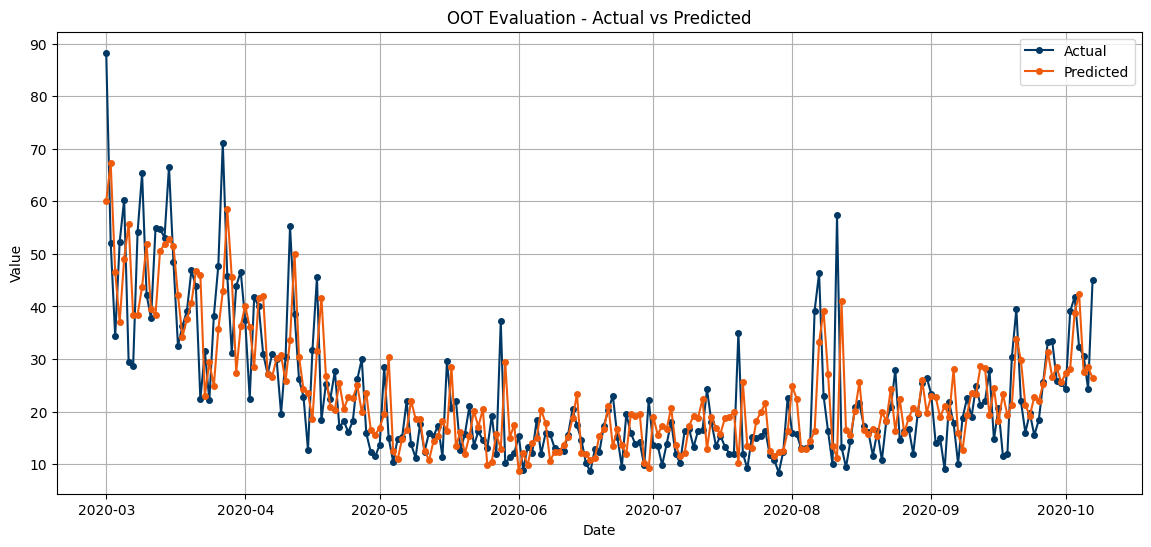

OOT Evaluation Metrics:
{'MSE': 89.27981073221389, 'RMSE': 9.448799433378502, 'MAE': 6.7579708631125746, 'MAPE': 31.578011314316214}


In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_on_oot_with_plot(model, oot_features, oot_target, scaler=None, date_col=None, title="OOT Evaluation"):
    # Scale features if a scaler is provided
    if scaler:
        oot_features = scaler.transform(oot_features)
    
    # Make predictions
    oot_predictions = model.predict(oot_features)
    
    # Calculate metrics
    mse = mean_squared_error(oot_target, oot_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(oot_target, oot_predictions)
    mape_val = mape(oot_target, oot_predictions)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val
    }
    
    # Plot actual vs predicted values
    plt.figure(figsize=(14, 6))
    if date_col is not None:
        plt.plot(date_col, oot_target, label="Actual", marker="o", c="#003865", markersize=4)
        plt.plot(date_col, oot_predictions, label="Predicted", marker="o", c="#EF5B0C", markersize=4)
        plt.xlabel("Date")
    else:
        plt.plot(oot_target.reset_index(drop=True), label="Actual", marker="o", c="#003865", markersize=4)
        plt.plot(oot_predictions, label="Predicted", marker="o", c="#EF5B0C", markersize=4)
        plt.xlabel("Index")

    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()
    
    return metrics

# Example Usage
# Assuming you have a trained model, OOT set, and optional scaler
oot_features = df_features_oot[best_features]  # Features from OOT set
oot_target = df_features_oot['value']  # Target column from OOT set
oot_dates = df_features_oot['date_time']  # Date column (optional)

metrics = evaluate_on_oot_with_plot(
    model,
    oot_features,
    oot_target,
    scaler=scaler,
    date_col=oot_dates,
    title="OOT Evaluation - Actual vs Predicted"
)

print("OOT Evaluation Metrics:")
print(metrics)


In [ ]:
{'MSE': 87.51142373002013, 'RMSE': 9.354754071060347, 'MAE': 6.703147948654316, 'MAPE': 31.332791262752313}

## no data leak

In [5]:
df_train = df[df['date_time'] < "2020-03-01"].copy()
df_test = df[df['date_time'] >= "2020-03-01"].copy()

In [66]:
feature_creation_pipeline.fit(df_train)
df_train_transformed = feature_creation_pipeline.transform(df_train)

In [ ]:
X_train = df_train_transformed.drop(columns=['value', 'date_time'], errors='ignore')
y_train = df_train_transformed['value']

best_features = ['value_roll30_median', 'value_lag1', 'f1s', 'value_roll90_mean', 'value_roll70_max', 'value_roll120_std', 'month']

model = LinearRegression()  # or any model
model.fit(X_train[best_features], y_train)

In [75]:
import numpy as np
import pandas as pd

def predict_autoregressive(
    df_train,         # historical data with known 'value'
    df_test,          # future data, 'value' is unknown/irrelevant
    pipeline,         # your feature engineering pipeline
    model, 
    features,
    date_col='date_time',
    target_col='value'
):
    """
    Iteratively predict out-of-time data using predicted values for lag features.
    """
    # 1) Start with a combined DF that has the entire training data
    df_combined = df_train.copy()
    
    # 2) We will store predictions in a list and then attach them to df_test
    predictions = []

    # 3) Sort test data by time to ensure we go in chronological order
    df_test_sorted = df_test.sort_values(by=date_col).copy()
    
    # 4) Iterate row-by-row (or day-by-day, etc.)
    for idx, row in df_test_sorted.iterrows():
        # This row is "unknown future" -- set the target to NaN
        row[target_col] = np.nan
        
        # Append to the combined df
        df_combined = pd.concat([df_combined, pd.DataFrame([row])], ignore_index=True)
        
        # Now transform the entire combined df
        # (the pipeline uses .shift, rolling, etc. under the hood)
        df_combined_trans = pipeline.transform(df_combined)
        
        # The features for the last row are what we need to make the next prediction
        # (exclude the target or date_time from features if not needed)
        X_latest = df_combined_trans.iloc[[-1]].drop(columns=[target_col, date_col], errors='ignore')
        
        # Predict
        y_pred = model.predict(X_latest[features])[0]
        
        # Store the prediction so that we can feed it to the next iteration's lag
        df_combined.loc[df_combined.index[-1], target_col] = y_pred
        
        # Keep track of predictions in a list
        predictions.append(y_pred)

    # Attach predictions to df_test_sorted and return
    df_test_sorted['prediction'] = predictions
    return df_test_sorted


# 1) Fit your pipeline + model on training
feature_creation_pipeline.fit(df_train)
df_train_transformed = feature_creation_pipeline.transform(df_train)

X_train = df_train_transformed
y_train = df_train_transformed['value']

best_features = ['value_roll30_median', 'value_lag1', 'f1s', 'value_roll90_mean', 'value_roll70_max', 'value_roll120_std', 'month']
needed_cols = best_features + ['value', 'date_time']  # so we can plot vs date_time
df_sub = X_train[needed_cols].copy()

df_sub.dropna(subset=best_features + ['value'], inplace=True)
df_sub.sort_values('date_time', inplace=True)
df_sub.reset_index(drop=True, inplace=True)

# Separate X, y
X_final = df_sub[best_features]
y_final = df_sub['value']

# 3) Optionally scale, then train
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

model = LinearRegression()  # or any model
model.fit(X_scaled, y_final)

# 2) Perform iterative predictions on out-of-time data
df_test_results = predict_autoregressive(
    df_train=df_train,
    df_test=df_test, 
    pipeline=feature_creation_pipeline,
    model=model,
    features=best_features,
    date_col='date_time',
    target_col='value'
)


c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [94]:
from sklearn.pipeline import Pipeline

# Pipeline A: date/time features only
datetime_pipeline = Pipeline([
    ("datetime_features", DateTimeFeatureEngineer(country='KZ')),
])

# Pipeline B: lag/rolling features
lag_rolling_pipeline = Pipeline([
    ("lag_rolling", LagRollingFeatureEngineer(
        lags=[1,7,30,60,90,120,150,180,250,300,365], 
        windows=[3,7,15,30,50,70,90,120]
    ))
])


# Subset train data
df_train = df[df['date_time'] < '2020-03-01'].copy()

# 2a) Apply date/time pipeline to training data
df_train_dt = datetime_pipeline.fit_transform(df_train)  # or transform only, fit isn't truly necessary

# 2b) Apply lag/rolling pipeline to training data
df_train_full = lag_rolling_pipeline.fit_transform(df_train_dt)

# 2c) Drop NaNs from training data and prepare feature matrix
X_train = df_train_full.copy() # example drop, keep whichever columns
y_train = df_train_full['value']

best_features = ['value_roll30_median', 'value_lag1', 'f1s', 'value_roll90_mean', 'value_roll120_std', 'month']
# best_features = ['value_roll30_median', 'value_lag1', 'f1s', 'value_roll90_mean', 'value_roll70_max', 'value_roll120_std', 'month']
needed_cols = best_features + ['value', 'date_time']  # so we can plot vs date_time
df_sub = X_train[needed_cols].copy()

df_sub.dropna(subset=best_features + ['value'], inplace=True)
df_sub.sort_values('date_time', inplace=True)
df_sub.reset_index(drop=True, inplace=True)

# Separate X, y
X_final = df_sub[best_features]
y_final = df_sub['value']

# 3) Optionally scale, then train
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

In [95]:
model = LinearRegression()  # or any model
model.fit(X_scaled, y_final)

LinearRegression()

In [7]:
df_oot = df[df['date_time'] >= '2020-03-01'].copy()


In [96]:
# Subset OOT data

# 3a) Apply the datetime pipeline (safe, since it doesn't need 'value')
df_oot_dt = datetime_pipeline.transform(df_oot)

# We'll create a container for all rows (train + OOT) because we need
# an up-to-date "value" column that has actual (for train) or predicted (for OOT).
# This df_master will be used by the lag/rolling pipeline (because it needs 'value').
df_master = pd.concat([df_train_dt, df_oot_dt], ignore_index=True)
# df_master now has actual train values, actual OOT from original,
#   but we will overwrite OOT 'value' with predictions as we go.

df_master.sort_values('date_time', inplace=True)  # ensure chronological
df_master.reset_index(drop=True, inplace=True)

# We'll store predictions here
df_predictions = []

# 3b) For each date in the OOT set (in chronological order)
oot_dates = df_master[df_master['date_time'] >= '2020-03-01']['date_time'].unique()

for curr_date in oot_dates:
    # 1) Subset everything up to curr_date
    #    Because we need a complete timeline for lag features
    df_up_to_current = df_master[df_master['date_time'] <= curr_date].copy()
    
    # 2) Apply lag/rolling pipeline *transform only* 
    #    (it is already fit on training data).
    df_features = lag_rolling_pipeline.transform(df_up_to_current)
    
    # 3) Get the row that corresponds exactly to `curr_date`
    row_current_date = df_features[df_features['date_time'] == curr_date].copy()
    print(row_current_date)
    # If the pipeline created NaNs for the current row (e.g. not enough history),
    # skip or handle accordingly:
    if row_current_date.dropna().empty:
        # Not enough data to make a prediction
        pred_value = None
    else:
        # 4) Build feature vector
        X_curr = row_current_date.drop(columns=['value','date_time'])
        
        # 5) Predict
        pred_value = model.predict(X_curr[best_features])[0]  # single value for that date
    
    # 6) Overwrite the 'value' in df_master for curr_date with the predicted value
    df_master.loc[df_master['date_time'] == curr_date, 'value'] = pred_value
    
    # 7) Store it somewhere if you want
    df_predictions.append({
        'date_time': curr_date,
        'predicted_value': pred_value
    })

df_predictions = pd.DataFrame(df_predictions)


      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1070 2020-03-01  88.292658  2020      3            6           61           0   

      trend  f1s  f1c  ...  value_roll70_median  value_roll70_sum  \
1070      0  0.0  1.0  ...            78.246439        5961.57852   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1070          85.820322         32.519973            80.672982   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1070        7723.82901           81.142641          31.975004   

      value_roll120_median  value_roll120_sum  
1070             74.015674        9737.116963  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1071 2020-03-02  52.098706  2020      3            0           62           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1071      1  0.017213  0.999852  ...            79.556427       7727.1445

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1077 2020-03-08  54.161964  2020      3            6           68           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1077      7  0.120208  0.992749  ...             80.69272      4.969795e+11   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1077       5.521994e+09      5.033276e+10            85.900963   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1077      4.969795e+11        4.141496e+09       4.359454e+10   

      value_roll120_median  value_roll120_sum  
1077             78.755333       4.969795e+11  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1078 2020-03-09  65.325328  2020      3            0           69           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1078      8  0.137279  0.990532  ...             80.6

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1083 2020-03-14  53.104731  2020      3            5           74           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1083     13  0.221922  0.975065  ...            90.965502      1.307516e+20   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1083       1.452796e+18      1.324218e+19            90.743368   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1083      1.307516e+20        1.089597e+18       1.146940e+19   

      value_roll120_median  value_roll120_sum  
1083             86.714122       1.307516e+20  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1084 2020-03-15  66.621681  2020      3            6           75           0   

      trend       f1s     f1c  ...  value_roll70_median  value_roll70_sum  \
1084     14  0.238673  0.9711  ...            90.965502

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1089 2020-03-20  46.863192  2020      3            4           80           0   

      trend      f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1089     19  0.32127  0.946988  ...            95.439892      3.439978e+28   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1089       3.822197e+26      3.483918e+27            95.439892   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1089      3.439978e+28        2.866648e+26       3.017514e+27   

      value_roll120_median  value_roll120_sum  
1089             91.969393       3.439978e+28  

[1 rows x 55 columns]
      date_time     value  year  month  day_of_week  day_of_year  is_holiday  \
1090 2020-03-21  43.82628  2020      3            5           81           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1090     20  0.337523  0.941317  ...             97.26413

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1095 2020-03-26  47.758634  2020      3            3           86           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1095     25  0.417194  0.908818  ...           102.821313      9.050326e+36   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1095       1.005592e+35      9.165931e+35           105.281435   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1095      9.050326e+36        7.541938e+34       7.938854e+35   

      value_roll120_median  value_roll120_sum  
1095             95.439892       9.050326e+36  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1096 2020-03-27  71.106285  2020      3            4           87           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1096     26  0.432776  0.901502  ...           105.47

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1102 2020-04-02  22.448062  2020      4            3           93           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1102     32  0.523416  0.852078  ...           129.122814      6.027320e+46   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1102       6.697022e+44      6.104310e+45           108.168017   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1102      6.027320e+46        5.022767e+44       5.287104e+45   

      value_roll120_median  value_roll120_sum  
1102            102.267116       6.027320e+46  

[1 rows x 55 columns]
      date_time     value  year  month  day_of_week  day_of_year  is_holiday  \
1103 2020-04-03  41.74913  2020      4            4           94           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1103     33  0.538005  0.842942  ...             136.86

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1107 2020-04-07  30.959573  2020      4            1           98           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1107     37  0.594727  0.803928  ...        604252.486351      6.264428e+53   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1107       6.960475e+51      6.344447e+52           120.958017   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1107      6.264428e+53        5.220356e+51       5.495093e+52   

      value_roll120_median  value_roll120_sum  
1107            107.207111       6.264428e+53  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1108 2020-04-08  29.982992  2020      4            2           99           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1108     38  0.608477  0.793572  ...         1.529592

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1114 2020-04-14  22.855934  2020      4            1          105           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1114     44  0.687053  0.726608  ...         4.024245e+15      4.171972e+63   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1114       4.635525e+61      4.225263e+62           160.605454   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1114      4.171972e+63        3.476644e+61       3.659612e+62   

      value_roll120_median  value_roll120_sum  
1114            112.871202       4.171972e+63  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1115 2020-04-15  12.709763  2020      4            2          106           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1115     45  0.699458  0.714673  ...         1.018676

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1121 2020-04-21  27.714118  2020      4            1          112           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1121     51  0.769415  0.638749  ...         2.680060e+25      2.778443e+73   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1121       3.087159e+71      2.813933e+72         2.481019e+11   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1121      2.778443e+73        2.315369e+71       2.437222e+72   

      value_roll120_median  value_roll120_sum  
1121            128.943538       2.778443e+73  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1122 2020-04-22  17.077647  2020      4            2          113           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1122     52  0.780296  0.625411  ...         6.784157

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1128 2020-04-28  15.883529  2020      4            1          119           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1128     58  0.840618  0.541628  ...         1.784861e+35      1.850382e+83   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1128       2.055980e+81      1.874018e+82         1.652305e+21   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1128      1.850382e+83        1.541985e+81       1.623137e+82   

      value_roll120_median  value_roll120_sum  
1128            142.724599       1.850382e+83  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1129 2020-04-29  12.316111  2020      4            2          120           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1129     59  0.849817  0.527078  ...         4.518101

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1135 2020-05-05  14.834118  2020      5            1          126           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1135     65  0.899631  0.436651  ...         1.188679e+45      1.232314e+93   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1135       1.369238e+91      1.248055e+92         1.100399e+31   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1135      1.232314e+93        1.026929e+91       1.080974e+92   

      value_roll120_median  value_roll120_sum  
1135          9.801188e+09       1.232314e+93  

[1 rows x 55 columns]
      date_time  value  year  month  day_of_week  day_of_year  is_holiday  \
1136 2020-05-06  15.08  2020      5            2          127           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1136     66  0.907014  0.421101  ...         3.008957e+46    

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


      date_time  value  year  month  day_of_week  day_of_year  is_holiday  \
1139 2020-05-09  11.19  2020      5            5          130           0   

      trend       f1s      f1c  ...  value_roll70_median  value_roll70_sum  \
1139     69  0.927542  0.37372  ...         4.880567e+50      5.059729e+98   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1139       5.621921e+96      5.124360e+97         4.518101e+36   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1139      5.059729e+98        4.216441e+96       4.438343e+97   

      value_roll120_median  value_roll120_sum  
1139          4.024245e+15       5.059729e+98  

[1 rows x 55 columns]
      date_time     value  year  month  day_of_week  day_of_year  is_holiday  \
1140 2020-05-10  17.62375  2020      5            6          131           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1140     70  0.933837  0.357698  ...         1.235440e+52     1.2

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1146 2020-05-16  29.619375  2020      5            5          137           0   

      trend      f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1146     76  0.96574  0.259512  ...         3.250351e+60     3.369669e+108   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1146      3.744077e+106     3.412712e+107         3.008957e+46   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1146     3.369669e+108       2.808058e+106      2.955840e+107   

      value_roll120_median  value_roll120_sum  
1146          2.680060e+25      3.369669e+108  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1147 2020-05-17  20.599412  2020      5            6          138           0   

      trend       f1s      f1c  ...  value_roll70_median  value_roll70_sum  \
1147     77  0.970064  0.24285  ...         8.227762e+61

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1153 2020-05-23  16.250526  2020      5            5          144           0   

      trend       f1s      f1c  ...  value_roll70_median  value_roll70_sum  \
1153     83  0.989932  0.14154  ...         2.164663e+70     2.244126e+118   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1153      2.493474e+116     2.272792e+117         2.003900e+56   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1153     2.244126e+118       1.870105e+116      1.968525e+117   

      value_roll120_median  value_roll120_sum  
1153          1.784861e+35      2.244126e+118  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1154 2020-05-24  14.516316  2020      5            6          145           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1154     84  0.992222  0.124479  ...         5.479510e+

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without featu

      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1159 2020-05-29  10.138889  2020      5            4          150           0   

      trend      f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1159     89  0.99925  0.038722  ...         5.695068e+78     5.904130e+126   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1159      6.560144e+124     5.979546e+125         5.272111e+64   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1159     5.904130e+126       4.920108e+124      5.179043e+125   

      value_roll120_median  value_roll120_sum  
1159          4.695838e+43      5.904130e+126  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1160 2020-05-30  11.274444  2020      5            5          151           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1160     90  0.999769  0.021516  ...         1.441618e+

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


      date_time  value  year  month  day_of_week  day_of_year  is_holiday  \
1161 2020-05-31  12.02  2020      5            6          152           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1161     91  0.999991  0.004304  ...         3.649234e+81     3.783195e+129   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1161      4.203550e+127     3.831520e+128         3.378216e+67   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1161     3.783195e+129       3.152663e+127      3.318581e+128   

      value_roll120_median  value_roll120_sum  
1161          3.008957e+46      3.783195e+129  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1162 2020-06-01  15.363333  2020      6            0          153           0   

      trend       f1s      f1c  ...  value_roll70_median  value_roll70_sum  \
1162     92  0.999917 -0.01291  ...         9.237473e+82     9

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


      date_time     value  year  month  day_of_week  day_of_year  is_holiday  \
1163 2020-06-02  8.890556  2020      6            1          154           0   

      trend       f1s      f1c  ...  value_roll70_median  value_roll70_sum  \
1163     93  0.999546 -0.03012  ...         2.338324e+84     2.424162e+132   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1163      2.693513e+130     2.455127e+131         2.164663e+70   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1163     2.424162e+132       2.020135e+130      2.126450e+131   

      value_roll120_median  value_roll120_sum  
1163          1.928052e+49      2.424162e+132  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1164 2020-06-03  13.256842  2020      6            2          155           0   

      trend      f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1164     94  0.99888 -0.047321  ...         5.919105e+85  

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1166 2020-06-05  18.308947  2020      6            4          157           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1166     96  0.996659 -0.081676  ...         3.792791e+88     3.932022e+136   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1166      4.368913e+134     3.982248e+135         3.511111e+74   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1166     3.932022e+136       3.276685e+134      3.449130e+135   

      value_roll120_median  value_roll120_sum  
1166          3.127326e+53      3.932022e+136  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1167 2020-06-06  11.886842  2020      6            5          158           0   

      trend       f1s      f1c  ...  value_roll70_median  value_roll70_sum  \
1167     97  0.995105 -0.09882  ...         9.600865e+

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1169 2020-06-08  15.692778  2020      6            0          160           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1169     99  0.991114 -0.133015  ...         6.151956e+92     6.377790e+140   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1169      7.086433e+138     6.459257e+139         5.695068e+78   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1169     6.377790e+140       5.314825e+138      5.594533e+139   

      value_roll120_median  value_roll120_sum  
1169          5.072562e+57      6.377790e+140  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1170 2020-06-09  13.088947  2020      6            1          161           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1170    100  0.988678 -0.150055  ...         1.557273

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


      date_time    value  year  month  day_of_week  day_of_year  is_holiday  \
1172 2020-06-11  12.4715  2020      6            3          163           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1172    102  0.982927 -0.183998  ...         9.978552e+96     1.034486e+145   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1172      1.149429e+143     1.047700e+144         9.237473e+82   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1172     1.034486e+145       8.620714e+142      9.074404e+143   

      value_roll120_median  value_roll120_sum  
1172          8.227762e+61      1.034486e+145  

[1 rows x 55 columns]
      date_time    value  year  month  day_of_week  day_of_year  is_holiday  \
1173 2020-06-12  15.5375  2020      6            4          164           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1173    103  0.979614 -0.200891  ...         2.525916e+98    

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


      date_time  value  year  month  day_of_week  day_of_year  is_holiday  \
1174 2020-06-13   20.4  2020      6            5          165           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1174    104  0.976011 -0.217723  ...         6.393967e+99     6.628685e+147   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1174      7.365205e+145     6.713357e+146         5.919105e+85   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1174     6.628685e+147       5.523904e+145      5.814615e+146   

      value_roll120_median  value_roll120_sum  
1174          5.272111e+64      6.628685e+147  

[1 rows x 55 columns]
      date_time   value  year  month  day_of_week  day_of_year  is_holiday  \
1175 2020-06-14  17.358  2020      6            6          166           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1175    105  0.972118 -0.234491  ...        1.618534e+101     1.677

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


      date_time     value  year  month  day_of_week  day_of_year  is_holiday  \
1178 2020-06-17  8.655789  2020      6            2          169           0   

      trend       f1s       f1c  ...  value_roll70_median  value_roll70_sum  \
1178    108  0.958718 -0.284359  ...        2.625283e+105     2.721655e+153   

      value_roll90_mean  value_roll90_std  value_roll90_median  \
1178      3.024061e+151     2.756420e+152         2.430311e+91   

      value_roll90_sum  value_roll120_mean  value_roll120_std  \
1178     2.721655e+153       2.268046e+151      2.387408e+152   

      value_roll120_median  value_roll120_sum  
1178          2.164663e+70      2.721655e+153  

[1 rows x 55 columns]
      date_time      value  year  month  day_of_week  day_of_year  is_holiday  \
1179 2020-06-18  12.915556  2020      6            3          170           0   

      trend       f1s      f1c  ...  value_roll70_median  value_roll70_sum  \
1179    109  0.953681 -0.30082  ...        6.645498e+106

c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [79]:
X_train

,year,month,day_of_week,day_of_year,is_holiday,trend,f1s,f1c,f2s,f2c,...,value_roll90_div_max_min,value_roll90_range,value_roll120_mean,value_roll120_std,value_roll120_min,value_roll120_max,value_roll120_median,value_roll120_sum,value_roll120_div_max_min,value_roll120_range
0,2017,3,2,81,0,0,0.000000,1.000000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,3,3,82,0,1,0.017213,0.999852,0.008607,0.999963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,3,4,83,0,2,0.034422,0.999407,0.017213,0.999852,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,3,5,84,0,3,0.051620,0.998667,0.025818,0.999667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,3,6,85,0,4,0.068802,0.997630,0.034422,0.999407,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,2020,2,1,56,0,1070,-0.417194,0.908818,0.213521,-0.976938,...,4.698150,139.635559,81.343337,31.700594,19.743021,177.393779,74.015674,9761.200384,8.985138,157.650758
1066,2020,2,2,57,0,1071,-0.401488,0.915864,0.205104,-0.978740,...,4.698150,139.635559,81.494581,31.552391,19.743021,177.393779,74.015674,9779.349708,8.985138,157.650758
1067,2020,2,3,58,0,1072,-0.385663,0.922640,0.196673,-0.980469,...,4.698150,139.635559,81.528083,31.522421,19.743021,177.393779,74.015674,9783.369994,8.985138,157.650758
1068,2020,2,4,59,0,1073,-0.369725,0.929141,0.188227,-0.982126,...,5.417109,144.646832,81.281148,31.788627,19.743021,177.393779,74.015674,9753.737790,8.985138,157.650758


In [ ]:
X_train

## sarima

In [10]:
import statsmodels.api as sm

# df_train.set_index('date_time', inplace=True)
# df_oot.set_index('date_time', inplace=True)

# The main “target” (endog) is 'value'
train_endog = df_train['value']


In [105]:

# Define your order and seasonal_order
# Example: SARIMAX(order=(1,1,1), seasonal_order=(1,1,1,7)) 
# for weekly seasonality in daily data
model = sm.tsa.statespace.SARIMAX(
    endog=train_endog,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

c:\Users\77019\pyver\py312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\77019\pyver\py312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [106]:
n_oot = len(df_oot)  # how many future points to predict

forecast_res = results.get_forecast(
    steps=n_oot, 
)

# The predicted mean
df_oot['forecast'] = forecast_res.predicted_mean

# (Optional) Confidence intervals
conf_int = forecast_res.conf_int()
df_oot['lower_ci'] = conf_int.iloc[:, 0]
df_oot['upper_ci'] = conf_int.iloc[:, 1]


c:\Users\77019\pyver\py312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\77019\pyver\py312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [107]:
df_oot

,value,forecast,lower_ci,upper_ci
date_time,,,,
2020-03-01,88.292658,NaN,NaN,NaN
2020-03-02,52.098706,NaN,NaN,NaN
2020-03-03,34.303057,NaN,NaN,NaN
2020-03-04,52.240744,NaN,NaN,NaN
2020-03-05,60.325065,NaN,NaN,NaN
...,...,...,...,...
2020-10-03,41.795789,NaN,NaN,NaN
2020-10-04,32.194444,NaN,NaN,NaN
2020-10-05,30.645000,NaN,NaN,NaN


In [24]:
aust = train_endog.copy()
aust

date_time
2017-03-22     91.982979
2017-03-23     84.649269
2017-03-24    126.039535
2017-03-25     63.183913
2017-03-26     38.572597
                 ...    
2020-02-25     59.761340
2020-02-26     55.543864
2020-02-27     32.746948
2020-02-28     31.529076
2020-02-29     59.566569
Name: value, Length: 1070, dtype: float64

In [30]:
clustered_df = pd.read_csv("../data/clusters0_df.csv")

In [31]:
clustered_df

,Unnamed: 0,full_date,0,1,2,3,4,5,6,7
0,0,2017-03-22 00:00:00,161.494444,148.020337,61.311806,41.486399,40.683844,40.319063,36.394024,39.834830
1,1,2017-03-23 00:00:00,43.078282,44.308725,32.940111,25.105712,84.649269,25.206332,26.172681,23.712832
2,2,2017-03-24 00:00:00,50.412605,54.905155,36.629707,31.421667,43.675636,26.540619,28.737027,13.845481
3,3,2017-03-25 00:00:00,37.531853,67.575610,74.986769,70.165374,58.792217,53.903601,65.958652,30.938544
4,4,2017-03-26 00:00:00,35.959271,45.677083,38.234516,21.692308,48.348401,31.451259,33.453506,16.188765
...,...,...,...,...,...,...,...,...,...,...
1286,216,2020-10-03,37.480000,37.090000,74.400000,25.850000,40.190000,32.140000,30.945000,27.440000
1287,217,2020-10-04,32.100000,NaN,103.820000,17.520000,26.680000,30.660000,24.565000,25.675000
1288,218,2020-10-05,32.510000,29.550000,75.030000,16.530000,25.935000,27.890000,17.750000,22.300000
1289,219,2020-10-06,21.440000,28.950000,35.300000,13.220000,23.473333,22.920000,17.600000,24.360000


In [33]:
time_series_data = {
    key:clustered_df[['full_date', str(key)]] for key in range(8)
}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import warnings
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
warnings.filterwarnings('ignore')

# Assuming you have your time series data in a dictionary:
# key: series name, value: DataFrame with 'value' column and datetime index


results_summary = []

for series_name, df in time_series_data.items():
    df.rename(columns={str(series_name): 'value'}, inplace=True)
    # Splitting into train and out-of-time (oot) datasets
    df_train = df.iloc[:-221]  # Adjust based on your data
    df_oot = df.iloc[-221:]
    
    # Applying the same logic for each time series
    fit1 = ExponentialSmoothing(
        df_train['value'],
        seasonal_periods=365,
        trend="add",
        seasonal="add",
        use_boxcox=True,
        initialization_method="estimated",
    ).fit()

    fit2 = ExponentialSmoothing(
        df_train['value'],
        seasonal_periods=360,
        trend="add",
        seasonal="mul",
        use_boxcox=True,
        initialization_method="estimated",
    ).fit()

    fit3 = ExponentialSmoothing(
        df_train['value'],
        seasonal_periods=369,
        trend="add",
        seasonal="add",
        damped_trend=True,
        use_boxcox=True,
        initialization_method="estimated",
    ).fit()

    fit4 = ExponentialSmoothing(
        df_train['value'],
        seasonal_periods=368,
        trend="add",
        seasonal="mul",
        damped_trend=True,
        use_boxcox=True,
        initialization_method="estimated",
    ).fit()

    # Forecasts
    forecast1 = fit1.forecast(221)
    forecast2 = fit2.forecast(221)
    forecast3 = fit3.forecast(221)
    forecast4 = fit4.forecast(221)
    
    # Evaluation
    predictions = {
        "Additive": forecast1,
        "Multiplicative": forecast2,
        "Additive Dam": forecast3,
        "Multiplica Dam": forecast4
    }
    errors = {}

    for model_name, forecast in predictions.items():
        forecast_values = pd.Series(forecast.values, index=df_oot.index)
        
        # Align forecast and actual data, dropping NaN values
        valid_data = pd.concat([df_oot['value'], forecast_values], axis=1).dropna()
        actual = valid_data.iloc[:, 0]  # Actual values (from df_oot)
        predicted = valid_data.iloc[:, 1]  # Forecasted values
        
        errors[model_name] = {
            "MAE": mean_absolute_error(actual, predicted),
            "MSE": mean_squared_error(actual, predicted),
            "RMSE": mean_squared_error(actual, predicted, squared=False),
            "MAPE": mean_absolute_percentage_error(actual, predicted)
        }
    # Append summary to results
    results_summary.append({
        "Series": series_name,
        "Errors": errors,
        "Fitted Values": {
            "Additive": fit1.fittedvalues,
            "Multiplicative": fit2.fittedvalues,
            "Additive Dam": fit3.fittedvalues,
            "Multiplica Dam": fit4.fittedvalues,
        },
        "Forecasts": predictions
    })

# To visualize or analyze results for a specific series:
for result in results_summary:
    print(f"Results for {result['Series']}")
    print(result["Errors"])
    # Visualization (as in your initial code)

# results

Results for 0
{'Additive': {'MAE': 9.29655920639201, 'MSE': 269.9008152866117, 'RMSE': 16.4286583532135, 'MAPE': 0.44492289728615314}, 'Multiplicative': {'MAE': 9.783957249084523, 'MSE': 258.0796954068274, 'RMSE': 16.06485902231412, 'MAPE': 0.5512447261864425}, 'Additive Dam': {'MAE': 8.66965187604705, 'MSE': 207.73950502313167, 'RMSE': 14.413171234087649, 'MAPE': 0.4509974278602268}, 'Multiplica Dam': {'MAE': 8.784149886449656, 'MSE': 208.891104984512, 'RMSE': 14.453065591233992, 'MAPE': 0.4844910601749691}}
Results for 1
{'Additive': {'MAE': 18.36947788356399, 'MSE': 1934.0846440638863, 'RMSE': 43.9782292056409, 'MAPE': 0.899485326808847}, 'Multiplicative': {'MAE': 20.63960857039717, 'MSE': 1932.6560333473178, 'RMSE': 43.96198395599677, 'MAPE': 1.0764116764340808}, 'Additive Dam': {'MAE': 21.072207542875024, 'MSE': 2043.0586988667371, 'RMSE': 45.2002068453977, 'MAPE': 1.0375819218818993}, 'Multiplica Dam': {'MAE': 20.02010161259854, 'MSE': 1979.347356578404, 'RMSE': 44.48985678307365

In [53]:
oot_clustered = clustered_df[clustered_df.full_date >= "2020-03-01"]

In [56]:
for id, result in enumerate(results_summary):
    mean_pred = pd.DataFrame(result['Forecasts']).mean(axis=1)
    valid_data = pd.concat([oot_clustered[str(id)], mean_pred], axis=1).dropna()
    actual = valid_data.iloc[:, 0]  # Actual values (from df_oot)
    predicted = valid_data.iloc[:, 1]  # Forecasted values
    print(mean_absolute_percentage_error(actual, predicted))

0.44875696508902374
0.9993819598834953
0.8080946350675119
0.4166199756254316
0.28738786559636575
0.3587911333097353
0.32652265738480496
0.5165601857148969


       date_time      value
1070  2020-03-01  88.292658
1071  2020-03-02  52.098706
1072  2020-03-03  34.303057
1073  2020-03-04  52.240744
1074  2020-03-05  60.325065
...          ...        ...
1286  2020-10-03  41.795789
1287  2020-10-04  32.194444
1288  2020-10-05  30.645000
1289  2020-10-06  24.271667
1290  2020-10-07  45.039524

[221 rows x 2 columns]
1mean absolute error :  12.17806
1mean squared error :  263.9273
1Root mean squared error :  16.24584
mean relative error 0.4581721978361977 %
2mean absolute error :  7.33906
2mean squared error :  125.35212
2Root mean squared error :  11.19608
mean relative error 0.2840501483832253 %
3mean absolute error :  9.85133
3mean squared error :  195.62247
3Root mean squared error :  13.98651
mean relative error 0.3546382352559363 %
4mean absolute error :  9.44124
4mean squared error :  189.46871
4Root mean squared error :  13.76476
mean relative error 0.3303058275220699 %


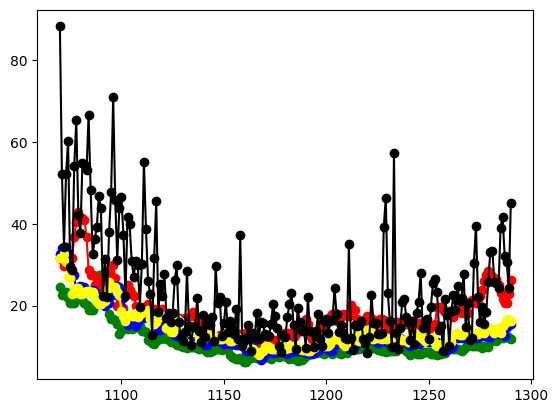

Figure 7.6: Forecasting.


In [26]:
forecast1 = fit1.forecast(221).rename("Holt-Winters (add-add-seasonal)")
forecast2 = fit2.forecast(221).rename("Holt-Winters (add-mul-seasonal)")
forecast3 = fit3.forecast(221).rename("Holt-Winters (add-add-seasonal heuristic)")
forecast4 = fit4.forecast(221).rename("Holt-Winters (add-mul-seasonal heuristic)")

predictions1 = pd.Series(forecast1.values, index=df_oot.index)
predictions2 = pd.Series(forecast2.values, index=df_oot.index)
predictions3 = pd.Series(forecast3.values, index=df_oot.index)
predictions4 = pd.Series(forecast4.values, index=df_oot.index)

predictions1.dropna(inplace=True)
predictions2.dropna(inplace=True)
predictions3.dropna(inplace=True)
predictions4.dropna(inplace=True)

print(df_oot[:len(predictions1)])

from sklearn.metrics import mean_absolute_percentage_error
print("1mean absolute error : ",round(mean_absolute_error(df_oot['value'][:len(predictions1)], predictions1), 5))
print("1mean squared error : ",round(mean_squared_error(df_oot['value'][:len(predictions1)], predictions1), 5))
print("1Root mean squared error : ",round(mean_squared_error(df_oot['value'][:len(predictions1)], predictions1,squared=False), 5))
print("mean relative error", mean_absolute_percentage_error(df_oot['value'], predictions1), "%")

print("2mean absolute error : ",round(mean_absolute_error(df_oot['value'][:len(predictions2)], predictions2),5))
print("2mean squared error : ",round(mean_squared_error(df_oot['value'][:len(predictions2)], predictions2),5))
print("2Root mean squared error : ",round(mean_squared_error(df_oot['value'][:len(predictions2)], predictions2,squared=False),5))
print("mean relative error", mean_absolute_percentage_error(df_oot['value'], predictions2), "%")

print("3mean absolute error : ",round(mean_absolute_error(df_oot['value'][:len(predictions3)], predictions3),5))
print("3mean squared error : ",round(mean_squared_error(df_oot['value'][:len(predictions3)], predictions3),5))
print("3Root mean squared error : ",round(mean_squared_error(df_oot['value'][:len(predictions3)], predictions3,squared=False),5))
print("mean relative error", mean_absolute_percentage_error(df_oot['value'], predictions3), "%")

print("4mean absolute error : ",round(mean_absolute_error(df_oot['value'][:len(predictions4)], predictions4),5))
print("4mean squared error : ",round(mean_squared_error(df_oot['value'][:len(predictions4)], predictions4),5))
print("4Root mean squared error : ",round(mean_squared_error(df_oot['value'][:len(predictions4)], predictions4,squared=False),5))
print("mean relative error", mean_absolute_percentage_error(df_oot['value'], predictions4), "%")

forecast1.plot(ax=ax, style="--", marker="o", color="green", legend=True, figsize=(20, 10))
forecast2.plot(ax=ax, style="--", marker="o", color="red", legend=True)
forecast3.plot(ax=ax, style="--", marker="o", color="blue", legend=True)
forecast4.plot(ax=ax, style="--", marker="o", color="yellow", legend=True)

plt.plot(predictions1, marker="o", color = "green")
plt.plot(predictions2, marker="o", color = "red")
plt.plot(predictions3, marker="o", color = "blue")
plt.plot(predictions4, marker="o", color = "yellow")
plt.plot(df_oot['value'], marker="o", color = 'black')
# plt.plot(df_train['value'], marker="o", color = 'black')
# Show the plot
plt.show()

print("Figure 7.6: Forecasting.")

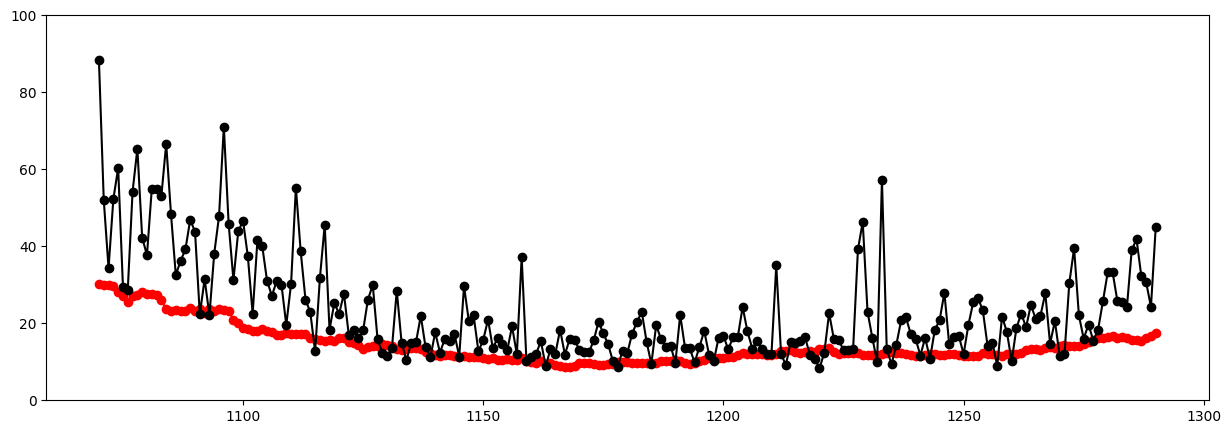

mean absolute error :  9.25623
mean squared error :  182.73343
Root mean squared error :  13.51789
mean relative error 0.3243902426513605 %


In [28]:
combined_predictions = pd.DataFrame({
    'predictions1': predictions1,
    'predictions2': predictions2,
    'predictions3': predictions3,
    'predictions4': predictions4
})
# Calculate the average prediction across all models
average_prediction = combined_predictions.mean(axis=1)

from sklearn.metrics import mean_absolute_percentage_error
plt.figure(figsize=(15, 5))
plt.plot(average_prediction, marker="o", color = "red")
plt.plot(df_oot['value'], marker="o", color = 'black')
plt.ylim(0, 100)

plt.show()
print("mean absolute error : ",round(mean_absolute_error(df_oot['value'], average_prediction),5))
print("mean squared error : ",round(mean_squared_error(df_oot['value'], average_prediction),5))
print("Root mean squared error : ",round(mean_squared_error(df_oot['value'], average_prediction,squared=False),5))
print("mean relative error", mean_absolute_percentage_error(df_oot['value'], average_prediction), "%")

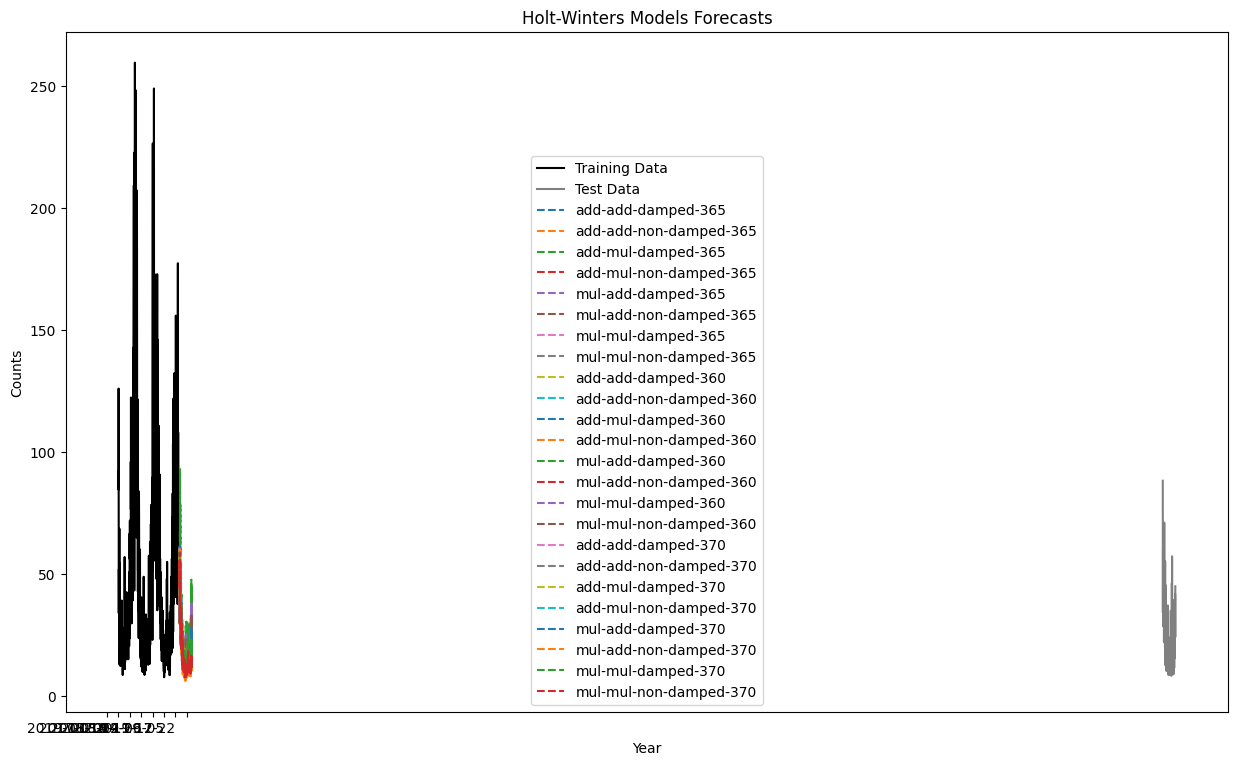

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings

warnings.filterwarnings('ignore')

# Function to fit and forecast Exponential Smoothing models
def fit_exponential_models(data, test_data, seasonal_periods_list, trends, seasonals, damped_options):
    results = []
    forecasts = {}
    
    for period in seasonal_periods_list:
        for trend in trends:
            for seasonal in seasonals:
                for damped in damped_options:
                    model_name = f"{trend}-{seasonal}-{'damped' if damped else 'non-damped'}-{period}"
                    try:
                        model = ExponentialSmoothing(
                            data,
                            seasonal_periods=period,
                            trend=trend,
                            seasonal=seasonal,
                            damped_trend=damped,
                            use_boxcox=True,
                            initialization_method="estimated",
                        ).fit()
                        
                        forecast = model.forecast(len(test_data)).rename(model_name)
                        forecasts[model_name] = forecast
                        
                        # Metrics
                        mae = mean_absolute_error(test_data, forecast)
                        mse = mean_squared_error(test_data, forecast)
                        rmse = mean_squared_error(test_data, forecast, squared=False)
                        mape = mean_absolute_percentage_error(test_data, forecast)
                        
                        results.append({
                            'Model': model_name,
                            'MAE': mae,
                            'MSE': mse,
                            'RMSE': rmse,
                            'MAPE': mape,
                            'SSE': model.sse,
                        })
                    except Exception as e:
                        print(f"Error for model {model_name}: {e}")
    
    results_df = pd.DataFrame(results).sort_values(by='MAPE')
    return results_df, forecasts

# Example Usage
seasonal_periods_list = [365, 360, 370, 365]
trends = ['add', 'mul']
seasonals = ['add', 'mul']
damped_options = [True, False]

# Assuming df_train and df_oot are your training and out-of-time datasets
results_df, forecasts = fit_exponential_models(df_train['value'], df_oot['value'], seasonal_periods_list, trends, seasonals, damped_options)

# Plot forecasts
fig, ax = plt.subplots(figsize=(15, 10))
df_train['value'].plot(ax=ax, color="black", label="Training Data")
df_oot['value'].plot(ax=ax, color="gray", label="Test Data")

# Plot all forecasts
for model_name, forecast in forecasts.items():
    forecast.plot(ax=ax, linestyle="--", label=model_name)

ax.set_title("Holt-Winters Models Forecasts")
ax.set_ylabel("Counts")
ax.set_xlabel("Year")
ax.legend(loc="best")
plt.show()


In [227]:
y_hat = pd.DataFrame(forecasts).mean(axis=1)

# Align actual and predicted values for the OOT period
actual_oot = df_oot['value']
predicted_oot = y_hat.copy()

# Calculate MAE
mae = mean_absolute_error(actual_oot, predicted_oot)

# Calculate MAPE (ensure no division by zero)
mape = mean_absolute_percentage_error(actual_oot, predicted_oot)

# Calculate RMSE
rmse = mean_squared_error(actual_oot, predicted_oot, squared=False)

# Print results
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 6.65
MAPE: 0.26
RMSE: 10.02


In [226]:
mape

0.2583907195109104

In [225]:
# Calculate the average fitted values
average_fitted_values = pd.DataFrame({
    'fit1': fit1.fittedvalues,
    'fit2': fit2.fittedvalues,
    'fit3': fit3.fittedvalues,
    'fit4': fit4.fittedvalues
}).mean(axis=1)

# Generate unknown data for n instances (simulating future predictions)
n = 200  # Adjust the number of unknown data points
future_index = pd.date_range(start=df_oot.index[0] + pd.Timedelta(days=1), periods=221+n, freq='D')
unknown_data = pd.Series(np.nan, index=future_index)

forecast1_future = fit1.forecast(221+n).rename("Holt-Winters (add-add-seasonal)")
forecast2_future = fit2.forecast(221+n).rename("Holt-Winters (add-mul-seasonal)")
forecast3_future = fit3.forecast(221+n).rename("Holt-Winters (add-add-seasonal heuristic)")
forecast4_future = fit4.forecast(221+n).rename("Holt-Winters (add-mul-seasonal heuristic)")

# Create predictions with future dates
predictions1_future = pd.Series(forecast1_future.values, index=future_index)
predictions2_future = pd.Series(forecast2_future.values, index=future_index)
predictions3_future = pd.Series(forecast3_future.values, index=future_index)
predictions4_future = pd.Series(forecast4_future.values, index=future_index)

# Drop NaN values in future predictions
predictions1_future.dropna(inplace=True)
predictions2_future.dropna(inplace=True)
predictions3_future.dropna(inplace=True)
predictions4_future.dropna(inplace=True)

# Combine predictions into a DataFrame
combined_predictions = pd.DataFrame({
    'Date': future_index,
    'predictions1': predictions1_future,
    'predictions2': predictions2_future,
    'predictions3': predictions3_future,
    'predictions4': predictions4_future
}).set_index('Date')

# Calculate the average prediction across all models
# average_future_prediction = combined_predictions.mean(axis=1)
average_future_prediction = combined_predictions.mean(axis=1)

# Combine train, OOT, and unknown data with appropriate indices
plot_data = pd.concat([
    df_train['value'].rename("Train Data"),
    average_fitted_values.rename("Average Fitted Values"),
    df_oot['value'].rename("OOT Data"),
    average_future_prediction.rename("Unknown Data")
], axis=1)

# Ensure index is in datetime format for consistent plotting
plot_data.index = pd.to_datetime(plot_data.index)

# Plotting
plt.figure(figsize=(15, 7))

# Plot each series
plot_data['Train Data'].plot(marker="o", color="blue", label="Train Data")
plot_data['Average Fitted Values'].plot(marker="o", color="orange", label="Average Fitted Values")
plot_data['OOT Data'].plot(marker="o", color="green", label="OOT Data")
plot_data['Unknown Data'].plot(marker="o", color="purple", label=f"{n} Instances of Unknown Data")

# Add labels and legend
plt.title("Train Data, Fitted Values, OOT Data, OOT Predictions and Future predictions")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()

# Use index directly for x-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Show plot
plt.show()



ValueError: time data "1070" doesn't match format "%Y-%m-%d", at position 1291. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [182]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Align actual and predicted values for the OOT period
actual_oot = df_oot['value']
predicted_oot = average_prediction.loc[actual_oot.index]

# Calculate MAE
mae = mean_absolute_error(actual_oot, predicted_oot)

# Calculate MAPE (ensure no division by zero)
mape = (np.abs((actual_oot - predicted_oot) / actual_oot)).mean() * 100

# Calculate RMSE
rmse = mean_squared_error(actual_oot, predicted_oot, squared=False)

# Print results
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")


MAE: 6.75
MAPE: 27.52%
RMSE: 10.09


In [202]:
import pandas as pd
import numpy as np
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare the training data
# Assuming `average_fitted_values` is the average of the fitted values from exponential models
X_train = average_fitted_values.loc[df_train.index]
y_train = df_train['value']

# Drop NaN values to align data
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

# Train the Isotonic Regression model
isotonic_regressor = IsotonicRegression(out_of_bounds="clip", increasing="auto", y_max=300)
isotonic_regressor.fit(X_train, y_train)

# Prepare the OOT data
X_oot = average_prediction.loc[df_oot.index]
y_oot = df_oot['value']

# Drop NaN values to align OOT data
X_oot = X_oot.dropna()
y_oot = y_oot.loc[X_oot.index]

# Make predictions on OOT data
y_pred_oot = isotonic_regressor.predict(X_oot)

# Evaluate the model on OOT data
mae = mean_absolute_error(y_oot, y_pred_oot)
mape = (np.abs((y_oot - y_pred_oot) / y_oot)).mean() * 100
rmse = mean_squared_error(y_oot, y_pred_oot, squared=False)

print("Isotonic Regression Results on OOT Data:")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")


Isotonic Regression Results on OOT Data:
MAE: 6.72
MAPE: 26.07%
RMSE: 10.08


## model on exponents data + data from dates

In [235]:
df_train

,value
date_time,
2017-03-22,91.982979
2017-03-23,84.649269
2017-03-24,126.039535
2017-03-25,63.183913
2017-03-26,38.572597
...,...
2020-02-25,59.761340
2020-02-26,55.543864
2020-02-27,32.746948


In [249]:
average_fitted_values

date_time
2017-03-22    96.955000
2017-03-23    77.484973
2017-03-24    72.499493
2017-03-25    67.811563
2017-03-26    56.182681
                ...    
2020-02-25    59.040134
2020-02-26    54.769114
2020-02-27    48.769462
2020-02-28    45.706297
2020-02-29    45.409519
Length: 1070, dtype: float64

In [273]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Ensure forecasts are aligned with the actual data
exponential_forecasts = pd.DataFrame({
    'fit1': fit1.fittedvalues,
    'fit2': fit2.fittedvalues,
    'fit3': fit3.fittedvalues,
    'fit4': fit4.fittedvalues
}).reset_index()
# aligned_actual, exponential_forecasts = df_oot['value'].align(exponential_forecasts, join='inner')

# Engineer datetime features
date_feature_engineer = DateTimeFeatureEngineer(country='KZ')
df_train_features = date_feature_engineer.fit_transform(df_train.reset_index()).reset_index()
df_oot_features = date_feature_engineer.transform(df_oot.reset_index()).reset_index()

# Add exponential forecasts to the feature set
exponential_forecasts_train = exponential_forecasts.loc[df_train_features.index]
exponential_forecasts_oot = exponential_forecasts.loc[df_oot_features.index]

# Add exponential forecasts to the feature set
# Drop 'date_time' from one of the DataFrames to avoid overlap
df_train_features = df_train_features.drop(columns=['date_time'], errors='ignore')
df_oot_features = df_oot_features.drop(columns=['date_time'], errors='ignore')

# Add exponential forecasts to the feature set
df_train_features = df_train_features.set_index(df_train.index)

# Align df_oot_features with df_oot
df_oot_features = df_oot_features.set_index(df_oot.index)

# Ensure target variable is aligned
y_train = df_train['value']
y_oot = df_oot['value']

# Train a linear regression model
df_train_features.drop(columns=['value', 'index'], inplace=True)
df_oot_features.drop(columns=['value', 'index'], inplace=True)

df_train_features['exp1'] = fit1.fittedvalues
df_train_features['exp2'] = fit2.fittedvalues
df_train_features['exp3'] = fit3.fittedvalues
df_train_features['exp4'] = fit4.fittedvalues

df_oot_features['exp1'] = predictions1
df_oot_features['exp2'] = predictions2
df_oot_features['exp3'] = predictions3
df_oot_features['exp4'] = predictions4

lr_model = LinearRegression()
lr_model.fit(df_train_features, y_train)

# Predict on OOT set
y_oot_pred = lr_model.predict(df_oot_features[df_train_features.columns])

# Evaluate the model
mae = mean_absolute_error(y_oot, y_oot_pred)
mse = mean_squared_error(y_oot, y_oot_pred)
rmse = mean_squared_error(y_oot, y_oot_pred, squared=False)
mape = mean_absolute_percentage_error(y_oot, y_oot_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape * 100:.2f}%")

MAE: 8.13
MSE: 138.72
RMSE: 11.78
MAPE: 30.34%


In [276]:
df_train_features

,year,month,day_of_week,day_of_year,is_holiday,trend,f1s,f1c,f2s,f2c,exp1,exp2,exp3,exp4
date_time,,,,,,,,,,,,,,
2017-03-22,2017,3,2,81,0,0,0.000000,1.000000,0.000000,1.000000,95.978326,91.648580,103.690213,96.502882
2017-03-23,2017,3,3,82,0,1,0.017213,0.999852,0.008607,0.999963,74.087725,73.452076,69.735254,92.664835
2017-03-24,2017,3,4,83,0,2,0.034422,0.999407,0.017213,0.999852,61.933615,76.769405,77.855545,73.439406
2017-03-25,2017,3,5,84,0,3,0.051620,0.998667,0.025818,0.999667,61.294900,60.320979,82.462394,67.167980
2017-03-26,2017,3,6,85,0,4,0.068802,0.997630,0.034422,0.999407,59.286866,52.302263,65.636196,47.505400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25,2020,2,1,56,0,1070,-0.417194,0.908818,0.213521,-0.976938,73.771636,54.335646,42.792789,65.260465
2020-02-26,2020,2,2,57,0,1071,-0.401488,0.915864,0.205104,-0.978740,58.146152,46.573328,56.730141,57.626836
2020-02-27,2020,2,3,58,0,1072,-0.385663,0.922640,0.196673,-0.980469,52.311818,36.982264,55.045346,50.738418


In [277]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=12
)

linear_forecaster.fit(train)

predictions = linear_forecaster.predict(len(val))

ModuleNotFoundError: No module named 'skforecast.ForecasterAutoreg'

In [271]:
df_train_features

,year,month,day_of_week,day_of_year,is_holiday,trend,f1s,f1c,f2s,f2c
date_time,,,,,,,,,,
2017-03-22,2017,3,2,81,0,0,0.000000,1.000000,0.000000,1.000000
2017-03-23,2017,3,3,82,0,1,0.017213,0.999852,0.008607,0.999963
2017-03-24,2017,3,4,83,0,2,0.034422,0.999407,0.017213,0.999852
2017-03-25,2017,3,5,84,0,3,0.051620,0.998667,0.025818,0.999667
2017-03-26,2017,3,6,85,0,4,0.068802,0.997630,0.034422,0.999407
...,...,...,...,...,...,...,...,...,...,...
2020-02-25,2020,2,1,56,0,1070,-0.417194,0.908818,0.213521,-0.976938
2020-02-26,2020,2,2,57,0,1071,-0.401488,0.915864,0.205104,-0.978740
2020-02-27,2020,2,3,58,0,1072,-0.385663,0.922640,0.196673,-0.980469


In [263]:
y_oot

date_time
2020-03-01    88.292658
2020-03-02    52.098706
2020-03-03    34.303057
2020-03-04    52.240744
2020-03-05    60.325065
                ...    
2020-10-03    41.795789
2020-10-04    32.194444
2020-10-05    30.645000
2020-10-06    24.271667
2020-10-07    45.039524
Name: value, Length: 221, dtype: float64

In [262]:
y_oot_pred

array([88.29265758, 52.09870588, 34.3030574 , 52.24074388, 60.32506459,
       29.45320157, 28.63861405, 54.16196374, 65.32532822, 42.237444  ,
       37.70725605, 54.91578533, 54.76664803, 53.10473056, 66.62168109,
       48.38662756, 32.5481057 , 36.22109934, 39.17123169, 46.86319224,
       43.82627958, 22.28877622, 31.47735174, 22.10074106, 38.12238735,
       47.75863436, 71.10628485, 45.85695112, 31.20929007, 43.89307555,
       46.62559145, 37.37300831, 22.44806196, 41.7491301 , 40.01343452,
       31.0151934 , 27.12740962, 30.95957346, 29.98299172, 19.57722872,
       30.28848863, 55.24768161, 38.65187135, 26.14792361, 22.85593381,
       12.70976333, 31.76065882, 45.57642353, 18.34563063, 25.251875  ,
       22.45647059, 27.71411765, 17.07764706, 18.12411765, 16.07944444,
       18.17166667, 26.15894737, 29.9575    , 15.88352941, 12.31611111,
       11.47555556, 13.65      , 28.494375  , 14.98823529, 10.40944444,
       14.83411765, 15.08      , 21.92466667, 13.7675    , 11.19

In [258]:
df_oot_features

,index,value,forecast,lower_ci,upper_ci,year,month,day_of_week,day_of_year,is_holiday,trend,f1s,f1c,f2s,f2c
date_time,,,,,,,,,,,,,,,
2020-03-01,0,88.292658,NaN,NaN,NaN,2020,3,6,61,0,0,0.000000,1.000000,0.000000,1.000000
2020-03-02,1,52.098706,NaN,NaN,NaN,2020,3,0,62,0,1,0.017213,0.999852,0.008607,0.999963
2020-03-03,2,34.303057,NaN,NaN,NaN,2020,3,1,63,0,2,0.034422,0.999407,0.017213,0.999852
2020-03-04,3,52.240744,NaN,NaN,NaN,2020,3,2,64,0,3,0.051620,0.998667,0.025818,0.999667
2020-03-05,4,60.325065,NaN,NaN,NaN,2020,3,3,65,0,4,0.068802,0.997630,0.034422,0.999407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-03,216,41.795789,NaN,NaN,NaN,2020,10,5,277,0,216,-0.545240,-0.838280,0.958718,-0.284359
2020-10-04,217,32.194444,NaN,NaN,NaN,2020,10,6,278,0,217,-0.559589,-0.828770,0.956235,-0.292600
2020-10-05,218,30.645000,NaN,NaN,NaN,2020,10,0,279,0,218,-0.573772,-0.819015,0.953681,-0.300820


## autots

,value
date_time,
2017-03-22,91.982979
2017-03-23,84.649269
2017-03-24,126.039535
2017-03-25,63.183913
2017-03-26,38.572597
...,...
2020-02-25,59.761340
2020-02-26,55.543864
2020-02-27,32.746948


In [282]:
from autots import AutoTS
model = AutoTS(forecast_length=221)
model = model.fit(df_train.reset_index(), date_col="date_time", value_col="value", id_col=None)

Using 2 cpus for n_jobs.
Data frequency is: D, used frequency is: D
Model Number: 1 with model AverageValueNaive in generation 0 of 25
Model Number: 2 with model AverageValueNaive in generation 0 of 25
Model Number: 3 with model AverageValueNaive in generation 0 of 25
Model Number: 4 with model DatepartRegression in generation 0 of 25
Model Number: 5 with model DatepartRegression in generation 0 of 25
Model Number: 6 with model DatepartRegression in generation 0 of 25
Model Number: 7 with model DatepartRegression in generation 0 of 25
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 7 in generation 0: DatepartRegression
Model Number: 8 with model ETS in generation 0 of 25
Model Number: 9 with model ETS in generation 0 of 25
Model Number: 10 with model GLM in generation 0 of 25
Model Number: 11 with model GLM in generation 0 of 25
Model Number: 12 with model GLS in generation 0 of 25
Model Number: 13 with model GLS in generation

In [ ]:
pred = model.predict()
forecast = prediction.forecast
mae = mean_absolute_error(y_oot, forecast)
mse = mean_squared_error(y_oot, forecast)
rmse = mean_squared_error(y_oot, forecast, squared=False)
mape = mean_absolute_percentage_error(y_oot, forecast)

mape